In [0]:
!pip install PyMaxflow

In [0]:
import maxflow as mf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os.path
from random import shuffle
import pickle
from PIL import Image
import pandas as pd
import skimage as sk
from skimage import metrics
import time

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd drive/My\ Drive/Colab\ Notebooks/Graphcut

/content/drive/My Drive/Colab Notebooks/Graphcut


# $\alpha$- $\beta$ SWAP Image Restoration

In image restoration experiences, we used the $\alpha$-$\beta$ Swap alogrorithm to minimize the objective function through its cycles. The PyMaxflow libary, which implemented our stuided Graph Cut alogrithm paper, is used to find a cut yielding the minimum cut - maxflow in each cycle of the $\alpha$-$\beta$ Swap alogrorithm. The energy definition and graph build technique for test image are referenced to the report.

In [0]:
def image_to_array(img):
    '''input: path to image
       output: array of grayscale
       '''
    from PIL import Image
    img = Image.open(img).convert('L')
    w, h = img.size

    data = list(img.getdata())
    data = [data[off:off+w] for off in range(0, w*h, w)]

    return data


def calculate_energy(img_orig, img_work,model):
    '''Calculates Energy of image.
       img: is input array'''

    E_data = 0
    for i in range(len(img_orig)):
        for j in range(len(img_orig[0])):
            E_data += D_p(img_orig[i][j], img_work, j, i)
    
    E_smooth = 0
    for i in range(len(img_orig)):
        for j in range(len(img_orig[0])):
            ns = give_neighbours(img_work, j, i)
            E_smooth += sum([V_p_q(v, img_work[i][j], model) for v in ns])

    return E_data + E_smooth

     
def V_p_q(label1, label2,model):
    '''Definition of the potential'''
    ## linear potential model
    if model == '1':
      return abs(label1-label2)
    ## truncated linear model
    elif model == '2':
      return min(200,abs(label1-label2))
    ## potts model
    else:
      if  abs(label1-label2)**2 < 255:
        return 0
      else:
        return 255
    
def D_p(label, graph, x, y):
    '''Returns the quadratic difference between label and real intensity of pixel'''
    return (abs(label**2-graph[y][x]**2))**0.5  


def give_neighbours(image, x, y):
    '''Returns a list of all neighbour intensities'''
    if x>=len(image[0]) or x<0 or y>=len(image) or y<0:
       raise ValueError('Pixel is not in image. x and/or y are to large')
    ns = []
    for a,b in zip([1,0,-1,0],[0,1,0,-1]):
        if (x+a<len(image[0]) and x+a>=0) and (y+b<len(image) and y+b>=0):
            ns.append(image[y+b][x+a])
    return ns 


def return_mapping_of_image(image, alpha, beta):
    #map does the position in graph map to (y,x) position in image
    map = {}
    #other way 
    revmap = {}
    #loop over all pixels and add them to maps
    map_parameter = 0
    for y in range(len(image)):
        for x in range(len(image[0])):
            #extract pixel which have the wanted label
            if image[y][x] == alpha or image[y][x] == beta:
                map[map_parameter] = (y,x)
                revmap[(y,x)] = map_parameter
                map_parameter += 1
    
    return map, revmap


def alpha_beta_swap_new(alpha, beta, img_orig, img_work):
    ''' Performs alpha-beta-swap
        img_orig: input image 
        img_work: denoised image in each step
        time_measure: flag if you want measure time'''

    #extract position of alpha or beta pixels to mapping 
    map, revmap = return_mapping_of_image(img_work, alpha, beta)
    
    #graph of maxflow 
    graph_mf = mf.Graph[float](len(map) )
    #add nodes
    nodes = graph_mf.add_nodes(len(map))
            
    #add n-link edges
    weight = V_p_q(alpha, beta,model)
    for i in range(0,len(map)):
        y,x = map[i]
        #top, left, bottom, right
        for a,b in zip([1,0,-1,0],[0,1,0,-1]):
            if (y+b, x+a) in revmap:
                graph_mf.add_edge(i,revmap[(y+b,x+a)], weight, 0)
   
    #add all the terminal edges
    for i in range(0,len(map)):
        y,x = map[i]
        #find neighbours
        neighbours = give_neighbours(img_work, x, y)
        #consider only neighbours which are not having alpha or beta label
        fil_neigh = list(filter(lambda i: i!=alpha and i!=beta, neighbours))
        #calculation of weight
        t_weight_alpha = sum([V_p_q(alpha,v,model) for v in fil_neigh]) + D_p(alpha, img_orig, x, y)
        t_weight_beta = sum([V_p_q(beta,v,model) for v in fil_neigh]) + D_p(beta, img_orig, x, y)
        graph_mf.add_tedge(nodes[i], t_weight_alpha, t_weight_beta)

    #calculating flow
    flow = graph_mf.maxflow()
    res = [graph_mf.get_segment(nodes[i]) for i in range(0, len(nodes))]
    
    #depending on cut assign new label
    for i in range(0, len(res)):
        y, x = map[i] 
        if res[i] == 1:
            img_work[y][x] = alpha 
        else:
            img_work[y][x] = beta
    
    return img_work


def swap_minimization(img_orig, img_work, cycles, output_name,model, min_energy):
    '''This methods implements the energy minimization via alpha-beta-swaps
       img_orig: is original input image
       img_work: optimized image
       cycles: how often to iterate over all labels'''

    #find all labels of image
    start = time.time()
    labels = []
    energy_per_cycle = []
    save_time = []
    
    for i in range(0, len(img_orig)):
        for j in range(0, len(img_orig[0])):
            if img_orig[i][j] not in labels:
                labels.append(img_orig[i][j])
    labels = np.array(labels) 

    energy_per_cycle.append(calculate_energy(img_orig, img_work,model))
    save_time.append(int(time.time()-start))
    #do iteration of all pairs a few times
    break_ = False
    for u in range(0,cycles):
      #iterate over all pairs of labels 
      for i in range(0, len(labels)-1):
        for j in range(i+1, len(labels)):
          #computing intensive swapping and graph cutting part
          img_work  = alpha_beta_swap_new(labels[i],labels[j], img_orig, img_work)   
          #user output and interims result image
        # if calculate_energy(img_orig, img_work, model) <= min_energy:
        #   break_ = True
        #   print('Break !!')
        if i%50 == 0:
          energy_per_cycle.append(calculate_energy(img_orig, img_work,model))
          save_time.append(int(time.time()-start))
          print('Save, i = ',i)
        if break_:
          break
      print(str(u+1) + "\t\t\t", calculate_energy(img_orig, img_work, model))
      if break_:
        break

    energy_per_cycle.append(calculate_energy(img_orig, img_work,model))
    save_time.append(int(time.time()-start))
    cv2.imwrite(output_name+".png",np.asarray(img_work))
    print('final-energy: ',calculate_energy(img_orig, img_work,model))
    
    with open(output_name+'_energy.pkl', 'wb') as f:
        pickle.dump(energy_per_cycle, f)
    with open(output_name+'_time.pkl', 'wb') as f:
        pickle.dump(save_time, f)
    stop = time.time()
    print('computational time: ',stop-start)

### Leopard restoration - 10 % noisy pixels (0.5 % pepper and 0.5 % salt noises)

In [0]:
src_path = './restoration/leopard/leopard_10/leopard_10.png'
ori_path = './restoration/leopard/leopard.png'
new_name = src_path.split('/')[-1].split('.')[0]
cycles = 1
## defining different smoothness terms
# 1: linear potential
# 2: truncated linear potential
# 3: potts model
models = ['1','2','3']

for model in models:
  print('Testing the model: ',model)
  sav_path = './restoration/leopard/leopard_10/model'+ model+ new_name
  img_src = image_to_array(src_path) 
  img_work = image_to_array(src_path)
  img_ori = image_to_array(ori_path)
  #min_energy = calculate_energy(img_src, img_ori,model)
  #print('Minimum Energy = ',min_energy) 
  print("#Energy input image:", calculate_energy(img_src, img_work,model))
  print("# nth cycle  \t\t energy")    
  #swap_minimization(img_src, img_work, cycles, sav_path,model,min_energy)
  swap_minimization(img_src, img_work, cycles, sav_path,model,0)

Testing the model:  1
#Energy input image: 8189160.0
# nth cycle  		 energy
Save, i =  0
Save, i =  50
Save, i =  100
Save, i =  150
Save, i =  200
Save, i =  250
1			 3909381.492205983
final-energy:  3909381.492205983
computational time:  613.2273139953613
Testing the model:  2
#Energy input image: 7613036.0
# nth cycle  		 energy
Save, i =  0
Save, i =  50
Save, i =  100
Save, i =  150
Save, i =  200
Save, i =  250
1			 3909681.0372615354
final-energy:  3909681.0372615354
computational time:  654.1946997642517
Testing the model:  3
#Energy input image: 23418690.0
# nth cycle  		 energy
Save, i =  0
Save, i =  50
Save, i =  100
Save, i =  150
Save, i =  200
Save, i =  250
1			 6964781.813337646
final-energy:  6964781.813337646
computational time:  588.6715495586395


### Leopard restoration - 15 % noisy pixels (0.5 % pepper and 0.5 % salt noises)

In [0]:
src_path = './restoration/leopard/leopard_15/leopard_15.png'
ori_path = './restoration/leopard/leopard.png'
new_name = src_path.split('/')[-1].split('.')[0]
cycles = 1
## defining different smoothness terms
# 1: linear potential
# 2: truncated linear potential
# 3: potts model
models = ['1','2','3']

for model in models:
  print('Testing the model: ',model)
  sav_path = './restoration/leopard/leopard_15/model'+ model+ new_name
  img_src = image_to_array(src_path) 
  img_work = image_to_array(src_path)
  img_ori = image_to_array(ori_path)
  #min_energy = calculate_energy(img_src, img_ori,model)
  #print('Minimum Energy = ',min_energy) 
  print("#Energy input image:", calculate_energy(img_src, img_work,model))
  print("# nth cycle  \t\t energy")   
  #swap_minimization(img_src, img_work, cycles, sav_path,model,min_energy)
  swap_minimization(img_src, img_work, cycles, sav_path,model,0)

Testing the model:  1
#Energy input image: 10195676.0
# nth cycle  		 energy
Save, i =  0
Save, i =  50
Save, i =  100
Save, i =  150
Save, i =  200
Save, i =  250
1			 4269712.551368013
final-energy:  4269712.551368013
computational time:  605.475711107254
Testing the model:  2
#Energy input image: 9353696.0
# nth cycle  		 energy
Save, i =  0
Save, i =  50
Save, i =  100
Save, i =  150
Save, i =  200
Save, i =  250
1			 4274642.654678778
final-energy:  4274642.654678778
computational time:  623.6874239444733
Testing the model:  3
#Energy input image: 25413810.0
# nth cycle  		 energy
Save, i =  0
Save, i =  50
Save, i =  100
Save, i =  150
Save, i =  200
Save, i =  250
1			 7267250.4509585025
final-energy:  7267250.4509585025
computational time:  600.3589932918549


### Leopard restoration - 25 % noisy pixels (0.5 % pepper and 0.5 % salt noises)

In [0]:
src_path = './restoration/leopard/leopard_25/leopard_25.png'
ori_path = './restoration/leopard/leopard.png'
new_name = src_path.split('/')[-1].split('.')[0]
cycles = 1
## defining different smoothness terms
# 1: linear potential
# 2: truncated linear potential
# 3: potts model
models = ['1','2','3']

for model in models:
  print('Testing the model: ',model)
  sav_path = './restoration/leopard/leopard_25/model'+ model+ new_name
  img_src = image_to_array(src_path) 
  img_work = image_to_array(src_path)
  img_ori = image_to_array(ori_path)
  #min_energy = calculate_energy(img_src, img_ori,model)
  #print('Minimum Energy = ',min_energy) 
  print("#Energy input image:", calculate_energy(img_src, img_work,model))
  print("# nth cycle  \t\t energy")   
  #swap_minimization(img_src, img_work, cycles, sav_path,model,min_energy)
  swap_minimization(img_src, img_work, cycles, sav_path,model,0)

Testing the model:  1
#Energy input image: 13344318.0
# nth cycle  		 energy
Save, i =  0
Save, i =  50
Save, i =  100
Save, i =  150
Save, i =  200
Save, i =  250
1			 4959403.26708453
final-energy:  4959403.26708453
computational time:  612.0686254501343
Testing the model:  2
#Energy input image: 12063620.0
# nth cycle  		 energy
Save, i =  0
Save, i =  50
Save, i =  100
Save, i =  150
Save, i =  200
Save, i =  250
1			 4986755.7370042885
final-energy:  4986755.7370042885
computational time:  648.8107335567474
Testing the model:  3
#Energy input image: 28440660.0
# nth cycle  		 energy
Save, i =  0
Save, i =  50
Save, i =  100
Save, i =  150
Save, i =  200
Save, i =  250
1			 7727634.823123625
final-energy:  7727634.823123625
computational time:  606.5987782478333


### Leopard restoration evaluation

**Approximate minimum energy validation**

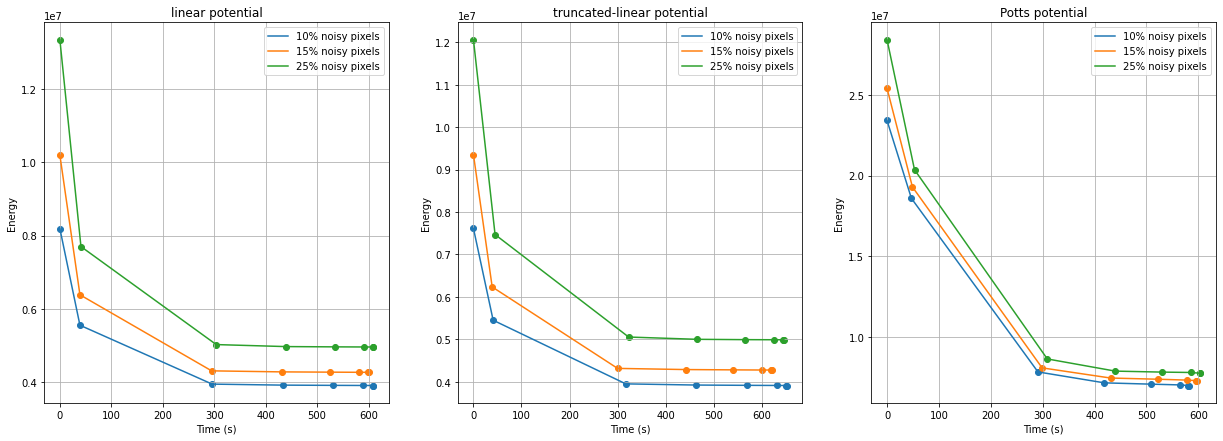

In [0]:
plt.subplots(1,3,figsize=(21,7))
models = ['1','2','3']
noisy_perc = ['10','15','25']
plt_nb = 1
for model in models: 
  plt.subplot(1,3,plt_nb)
  if model == '1':
    title = 'linear'
  elif model == '2':
    title = 'truncated-linear'
  else:
    title = 'Potts'
  for noip in noisy_perc:
    path0 = './restoration/leopard/leopard_'+noip+'/model' 
    path1 = path0 + model
    path2 = path1 +'leopard_'+noip+'_energy.pkl'
    path3 = path1 +'leopard_'+noip+'_time.pkl'
    energy_minimization =  np.asarray(pd.read_pickle(path2))
    time_ = np.asarray(pd.read_pickle(path3))
    plt.plot(time_,energy_minimization, label = noip+'% noisy pixels');
    plt.scatter(time_,energy_minimization)
  #plt.plot(cycle_plot, np.ones(6)*calculate_energy(img_orig, img_orig,model), label = 'Minimum Energy')
  plt.xlabel('Time (s)');
  plt.ylabel('Energy');
  plt.title(title+' potential')
  plt.legend()
  plt.grid()
  plt_nb += 1

**Result visualization**

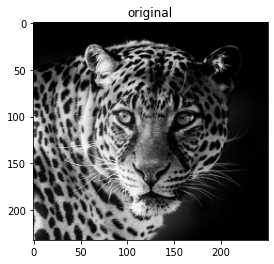

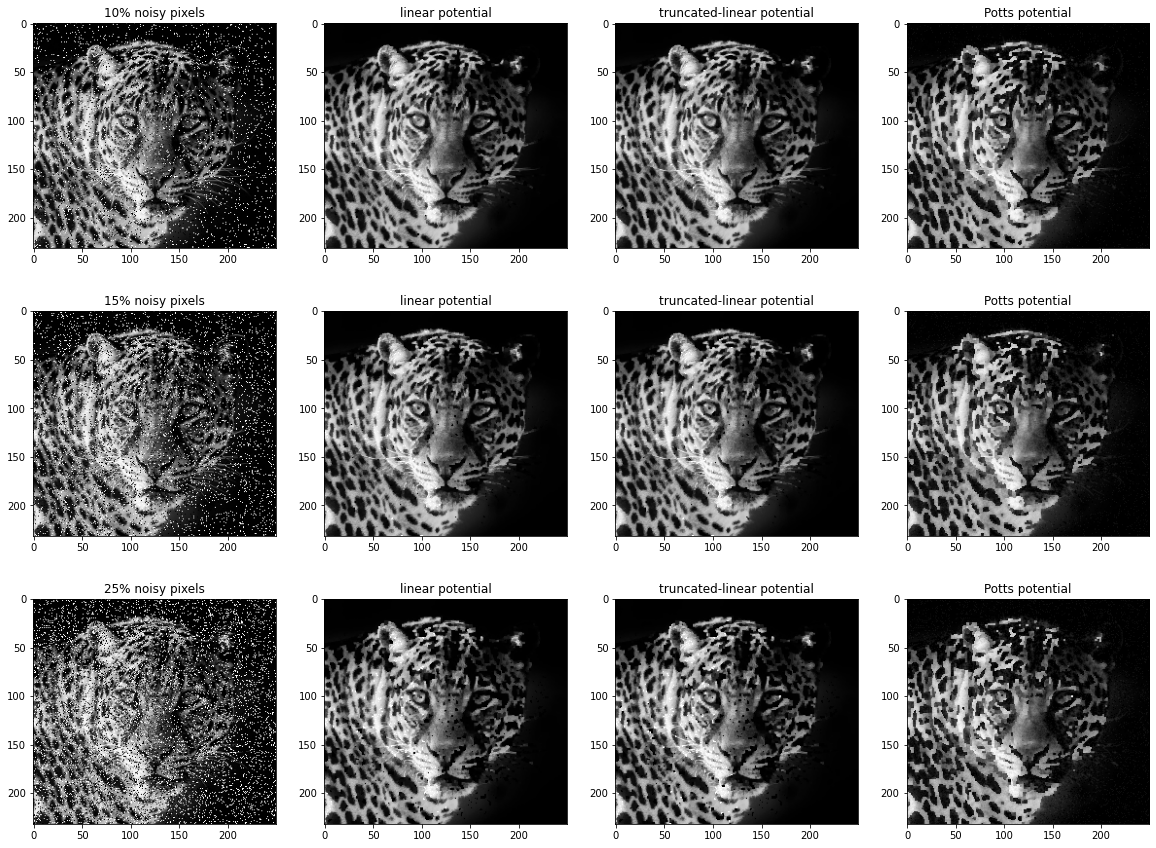

In [0]:
ori_path = './restoration/leopard/leopard.png'
ori_img = cv2.imread(ori_path)
plt.plot(figsize = (5,5))
plt.imshow(ori_img,cmap ='gray')
plt.title('original')
models = ['1','2','3']
noisy_perc = ['10','15','25']
plt_nb = 1
plt.subplots(3,4,figsize=(20,15))
for noip in noisy_perc:
  #print('Noise: ',noip)
  path0 = './restoration/leopard/leopard_'+noip+'/leopard_'+noip+'.png' 
  noisy = cv2.imread(path0)
  plt.subplot(3,4,plt_nb)
  plt.imshow(noisy, cmap ='gray')
  plt.title(noip+'% noisy pixels')
  plt_nb += 1
  for model in models:
    #print(model)
    path0 = './restoration/leopard/leopard_'+noip+'/model' 
    path1 = path0 + model
    path2 = path1 +'leopard_'+noip+'.png'
    if model == '1':
      title = 'linear'
    elif model == '2':
      title = 'truncated-linear'
    elif model == '3':
      title = 'Potts'
    recovered_img = cv2.imread(path2)
    plt.subplot(3,4,plt_nb)
    plt.imshow(recovered_img, cmap = 'gray')
    #print(metrics.peak_signal_noise_ratio(ori_img,recovered_img))
    plt.title(title+' potential')
    plt_nb += 1

# Image Segementation

In [0]:
def segmentation(seeds, img):
    
    ## convert a coordinate to a node number
    def get_node_num(x, y, array_shape):
        return y * array_shape[1] + x
    
    ## convert a node number to a coordinate
    def get_xy(nodenum, array_shape):
        return (nodenum % array_shape[1]), (nodenum // array_shape[1])
    
    def boundaryPenalty(current_pixel, neighboor_pixel):
        bp = 1 / (1 + np.sum(np.power(current_pixel -neighboor_pixel, 2)))
        return bp

    foreground = 1
    background = 0
    default = 0.5

    fgseed = []
    bckseed = []
    
    ###
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ### Retrieve the seeds
    y,x = np.where(seeds == 1) ## object seeds
    for i in range(x.shape[0]):
        fgseed.append((x[i],y[i]))
    y,x = np.where(seeds == 2) ## background seeds
    for i in range(x.shape[0]):
        bckseed.append((x[i],y[i]))

    #### initiation
    # graph
    graph = np.ones_like(img[:,:,0])*0.5
    # width, height of the image
    wh = img[:,:,0].shape
    # nodes
    nodes = []
    # edges
    edges = []
    K  = -float("inf")
    #### make n-link egdes and its weights for the graph
    for (y,x), value in np.ndenumerate(graph):
        if y == graph.shape[0] -1 or x == graph.shape[1] -1:
            continue
        current_index = get_node_num(x, y, img_gray.shape)
        left_neighbor_index = get_node_num(x+1, y, wh)
        bp = boundaryPenalty(img[y, x],img[y, x+1])
        edges.append((current_index, left_neighbor_index, bp))
        K = max(K, bp)
        below_neighbor_index = get_node_num(x, y+1, wh)
        bp = boundaryPenalty(img[y, x],img[y+1, x])
        edges.append((current_index, below_neighbor_index, bp))
        K = max(K, bp)

    #### add predifined seed into the graph
    for coordinate in fgseed:
        graph[coordinate[1],coordinate[0]] = foreground
    for coordinate in bckseed:
        graph[coordinate[1],coordinate[0]] = background

    #### make t-link edges and its weights for the graph
    for (y,x), value in np.ndenumerate(graph):
        if value == background: # background seed pixel
            nodes.append((get_node_num(x, y, img_gray.shape), 0, K))
        elif value == foreground: # foreground seed pixel
            nodes.append((get_node_num(x, y, img_gray.shape), K,0))
        else:
            nodes.append((get_node_num(x, y, img_gray.shape), 0, 0))
            
    ### find a min-cut/ max-flow problem
    g = mf.Graph[float](len(nodes), len(edges))
    nodelist = g.add_nodes(len(nodes))

    ## add t edges
    for node in nodes:
        g.add_tedge(node[0], node[1], node[2])

    ## add n edges
    for edge in edges:
        g.add_edge(edge[0], edge[1], edge[2], edge[2])

    ## find max flow
    flow = g.maxflow()
    
    # get a segment overlay
    #segment_overlay = np.zeros_like(img)
    mask = np.zeros_like(img, dtype=bool)
    for index in range(len(nodes)):
        if g.get_segment(index) == 0:
            xy = get_xy(index, wh)
            #segment_overlay[xy[1], xy[0]] = (255, 255, 255)
            mask[xy[1], xy[0]] = (True, True, True)
    
    return flow, mask

To generate fore ground and background seeds for testing image. We use a separte file seeds.py to put the seeds on a image. Run this file on your termnial with suitable parameter setting.

Example: > python .\seeds.py -sp ".\img_test\man.jpg" -op ".\seeded_imgs" -savimg "man"

Use -h to see parameter descriptions

In [0]:
#### hat segementation
# load the seeded image
seededimg_hat = cv2.imread('./segmentation/seeded_imgs/hat.jpg')
# load the seed file
seeds_hat = np.load('./segmentation/seeded_imgs/hat.pkl', allow_pickle = True)
img_hat = cv2.imread('./segmentation/test_imgs/hat.jpg')
start = time.time()
print('Image size: ',img_hat.shape)
flow_hat, mask_hat = segmentation(seeds_hat, img_hat)
stop = time.time()
print('segmentation time: ',stop - start)

Image size:  (181, 229, 3)
segmentation time:  1.1946825981140137


flow:  1.90452033350229


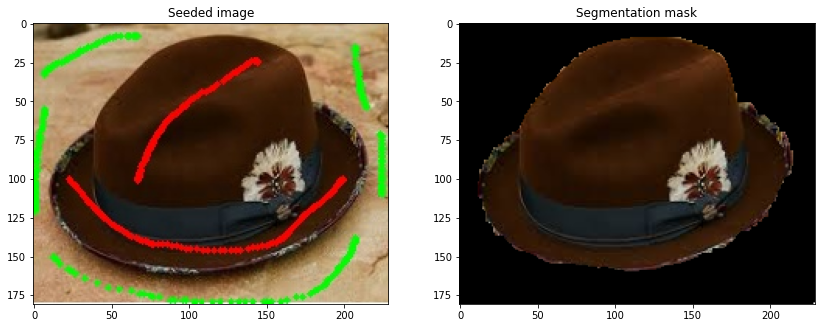

In [0]:
print('flow: ',flow_hat)
plt.figure( figsize = (14,7))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(seededimg_hat, cv2.COLOR_BGR2RGB));
plt.title('Seeded image')
plt.subplot(1,2,2)
plt.imshow(np.multiply(cv2.cvtColor(img_hat,cv2.COLOR_BGR2RGB),mask_hat))
plt.title('Segmentation mask');

In [0]:
###  baby segmentation
#load the seeded image
seededimg_baby = cv2.imread('./segmentation/seeded_imgs/baby.jpg')
#load the seed file
seeds_baby = np.load('./segmentation/seeded_imgs/baby.pkl', allow_pickle = True)
img_baby = cv2.imread('./segmentation/test_imgs/baby.jpg')
start = time.time()
print('Image size: ',img_baby.shape)
flow_baby, mask_baby = segmentation(seeds_baby, img_baby)
stop = time.time()
print('segmentation time: ',stop - start)

Image size:  (596, 571, 3)
segmentation time:  10.147835969924927


flow:  1.90452033350229


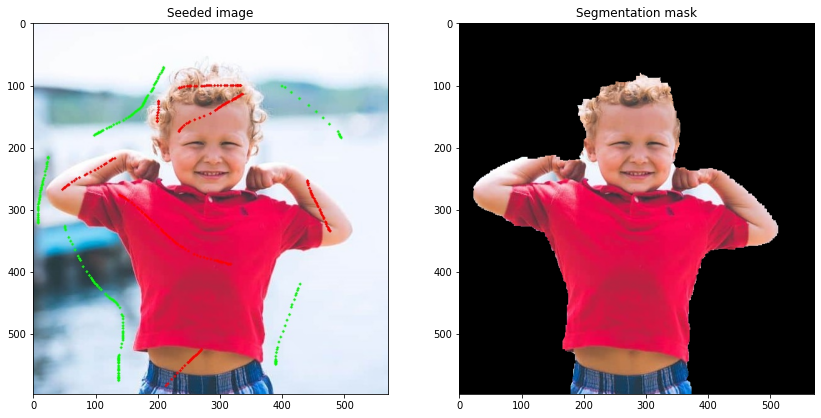

In [0]:
print('flow: ',flow_hat)
plt.figure( figsize = (14,7))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(seededimg_baby, cv2.COLOR_BGR2RGB));
plt.title('Seeded image')
plt.subplot(1,2,2)
plt.imshow(np.multiply(cv2.cvtColor(img_baby,cv2.COLOR_BGR2RGB),mask_baby))
plt.title('Segmentation mask');

In [0]:
###  Whale segmentation
#load the seeded image
seededimg_whale = cv2.imread('./segmentation/seeded_imgs/whale.jpg')
#load the seed file
seeds_whale = np.load('./segmentation/seeded_imgs/whale.pkl', allow_pickle = True)
img_whale = cv2.imread('./segmentation/test_imgs/whale.jpg')
start = time.time()
print('Image size: ',img_whale.shape)
flow_whale, mask_whale = segmentation(seeds_whale, img_whale)
stop = time.time()
print('segmentation time: ',stop - start)

Image size:  (733, 1277, 3)
segmentation time:  26.85180926322937


flow:  1.90452033350229


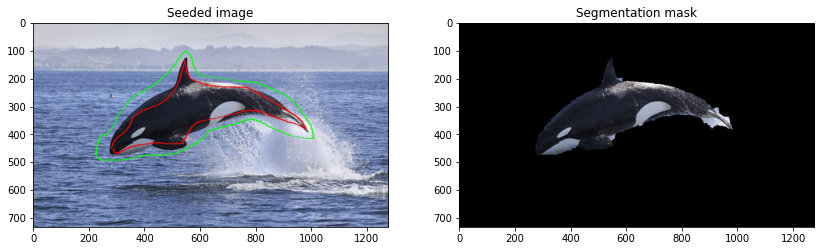

In [0]:
print('flow: ',flow_hat)
plt.figure( figsize = (14,7))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(seededimg_whale, cv2.COLOR_BGR2RGB));
plt.title('Seeded image')
plt.subplot(1,2,2)
plt.imshow(np.multiply(cv2.cvtColor(img_whale,cv2.COLOR_BGR2RGB),mask_whale))
plt.title('Segmentation mask');

# $\alpha$ Expansion Reconstruction


In [1]:
!pip install pymaxflow

     |████████████████████████████████| 133kB 5.0MB/s 
  Created wheel for pymaxflow: filename=PyMaxflow-1.2.12-cp36-cp36m-linux_x86_64.whl size=537275 sha256=fa5693f3eae529007356524b374aa35e0ae981fedd7de1e835f670847230d636
  Stored in directory: /root/.cache/pip/wheels/56/ab/a8/12b43e2024215b384364145b140e14a838b45ad39989f51a4f
Successfully built pymaxflow


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


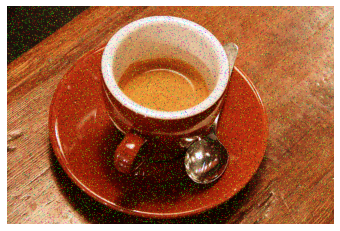

In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imageio
from maxflow.fastmin import aexpansion_grid
import time
img = imageio.imread('imageio:coffee.png')

plt.imshow(img)
# salt and peppering manually
def add_salt_and_pepper_noise(img):
  rows, cols = img.shape[:2]
  salt_vs_pepper_ratio = 0.5
  amount = 0.05
  img_salted_and_peppered = img.copy()
  num_salt = np.ceil(amount * img.size * salt_vs_pepper_ratio)
  coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape]
  img_salted_and_peppered[coords] = 255
  num_pepper = np.ceil(amount * img.size * (1 - salt_vs_pepper_ratio))
  coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]
  img_salted_and_peppered[coords] = 0
  return img_salted_and_peppered

img_salted_and_peppered = add_salt_and_pepper_noise(img)
# show salt and peppered image
plt.imshow(img_salted_and_peppered)
plt.axis("off")
plt.show()

In [0]:
def reconstruct_with_alpha_expansion(img,n_gray_levels):
  start = time.time()
  levs = np.arange(0.5/n_gray_levels, 1, 1/n_gray_levels) # Generates the number of gray levels (n_gray_levels) for nearsest prototype labeling
  img = img[:,:,1]/img.max()
  D = np.abs(img.reshape(img.shape+(1,)) - levs.reshape((1,1,-1))) # Calculate data cost as the absolute difference between the label prototype and the pixel value
  direct_labeling_img = np.argmin(D,2) # Generate nearest prototype labeling
  alpha = 1
  V = alpha * np.abs( levs.reshape((-1,1)) - levs.reshape((1,-1))) # Calculate neighbourhood cost as absolute difference between prototypes 
  reconstructed_img = aexpansion_grid(D,V) # Mimimise data + neighbourhood cost
  print((time.time()-start))

  return direct_labeling_img,reconstructed_img

### Reconstruction with 16 levels of gray

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


3.0119190216064453


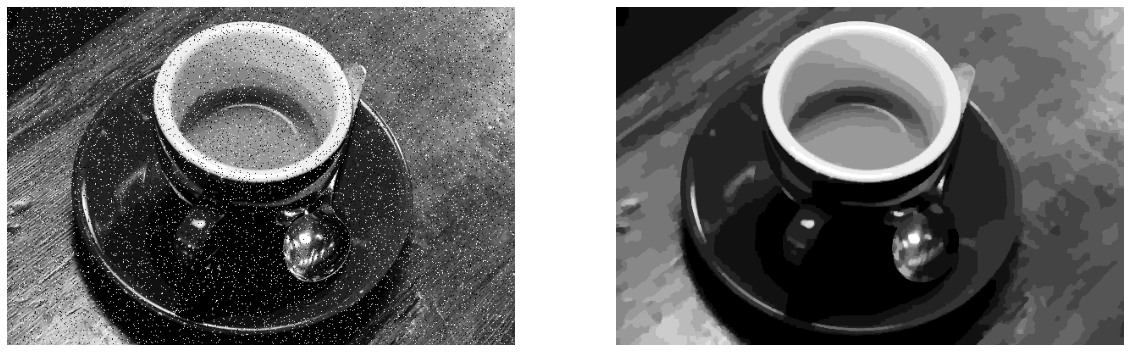

In [19]:
# Loading image
I = imageio.imread('imageio:coffee.png')
I = add_salt_and_pepper_noise(I)
direct_labeling_img,reconstructed_img = reconstruct_with_alpha_expansion(I,n_gray_levels = 16)

fg = plt.figure(figsize=(20,20))
ax1 = fg.add_subplot(1,2,1)
ax1.imshow(direct_labeling_img, cmap='gray')
plt.axis('off')
ax2 = fg.add_subplot(1,2,2)
ax2.imshow(reconstructed_img, cmap='gray')
plt.axis('off')
plt.show()

### Reconstruction with 32 levels of gray

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


7.146596431732178


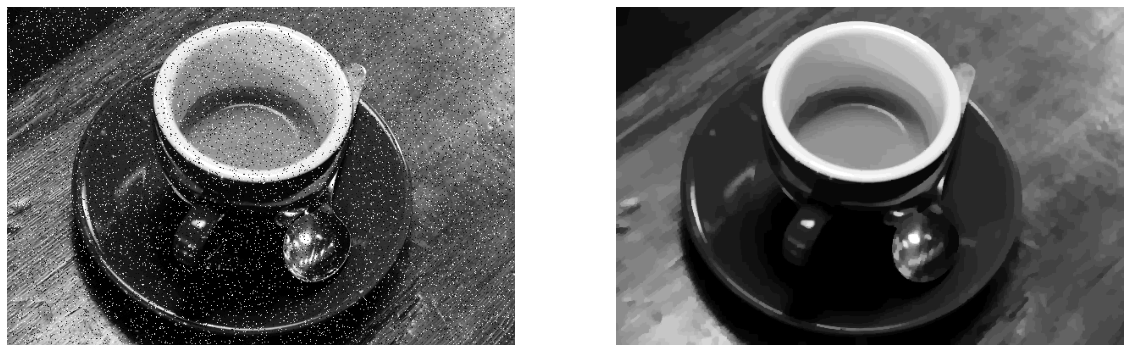

In [20]:
# Loading image
I = imageio.imread('imageio:coffee.png')
I = add_salt_and_pepper_noise(I)
direct_labeling_img,reconstructed_img = reconstruct_with_alpha_expansion(I,n_gray_levels = 32)

fg = plt.figure(figsize=(20,20))
ax1 = fg.add_subplot(1,2,1)
ax1.imshow(direct_labeling_img, cmap='gray')
plt.axis('off')
ax2 = fg.add_subplot(1,2,2)
ax2.imshow(reconstructed_img, cmap='gray')
plt.axis('off')
plt.show()

### Reconstruction with 64 levels of gray

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


16.7635440826416


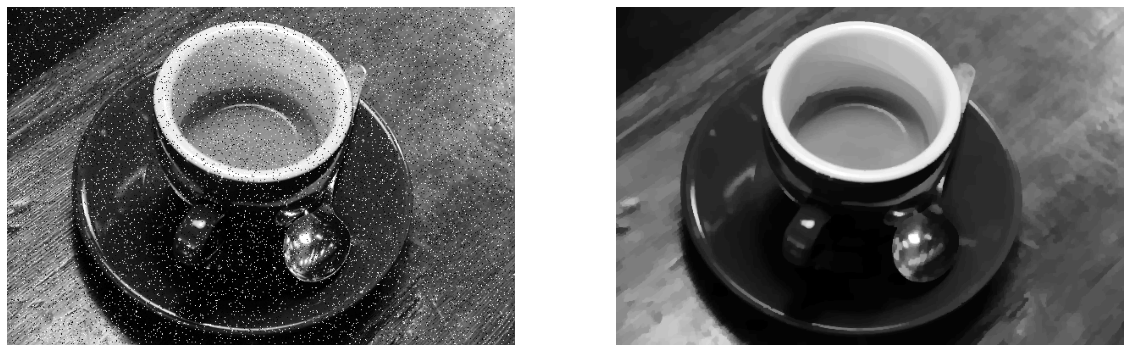

In [21]:
# Loading image
I = imageio.imread('imageio:coffee.png')
I = add_salt_and_pepper_noise(I)
direct_labeling_img,reconstructed_img = reconstruct_with_alpha_expansion(I,n_gray_levels = 64)

fg = plt.figure(figsize=(20,20))
ax1 = fg.add_subplot(1,2,1)
ax1.imshow(direct_labeling_img, cmap='gray')
plt.axis('off')
ax2 = fg.add_subplot(1,2,2)
ax2.imshow(reconstructed_img, cmap='gray')
plt.axis('off')
plt.show()

### Reconstruction with 128 levels of gray

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


39.52498745918274


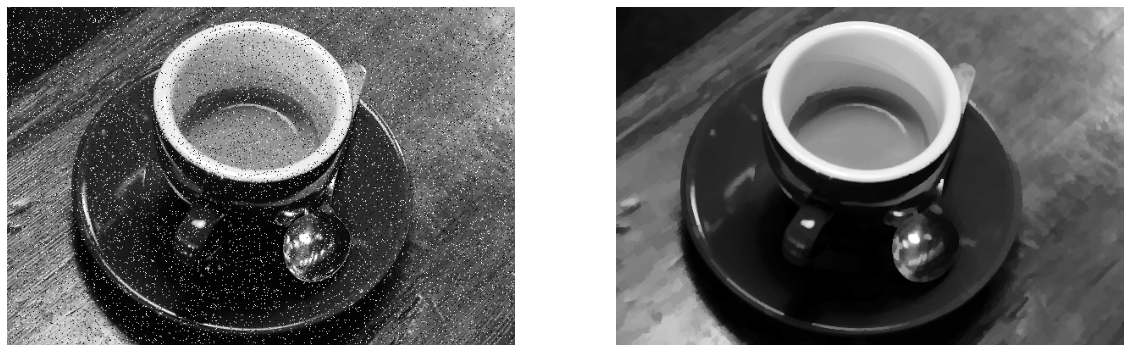

In [22]:
# Loading image
I = imageio.imread('imageio:coffee.png')
I = add_salt_and_pepper_noise(I)
direct_labeling_img,reconstructed_img = reconstruct_with_alpha_expansion(I,n_gray_levels = 128)

fg = plt.figure(figsize=(20,20))
ax1 = fg.add_subplot(1,2,1)
ax1.imshow(direct_labeling_img, cmap='gray')
plt.axis('off')
ax2 = fg.add_subplot(1,2,2)
ax2.imshow(reconstructed_img, cmap='gray')
plt.axis('off')
plt.show()

### Reconstruction with 256 levels of gray

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


89.0749089717865


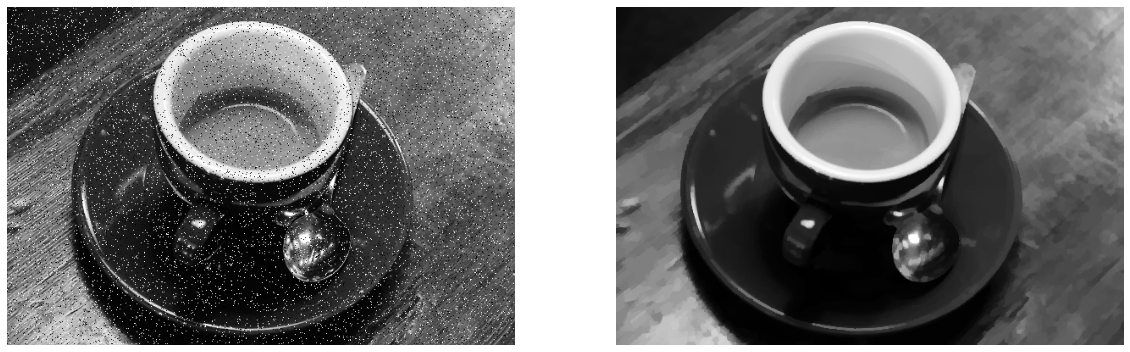

In [23]:
# Loading image
I = imageio.imread('imageio:coffee.png')
I = add_salt_and_pepper_noise(I)
direct_labeling_img,reconstructed_img = reconstruct_with_alpha_expansion(I,n_gray_levels = 256)

fg = plt.figure(figsize=(20,20))
ax1 = fg.add_subplot(1,2,1)
ax1.imshow(direct_labeling_img, cmap='gray')
plt.axis('off')
ax2 = fg.add_subplot(1,2,2)
ax2.imshow(reconstructed_img, cmap='gray')
plt.axis('off')
plt.show()